# Projeto 9.1 - Regressão Carros Usados - Validação Cruzada

## 1. Importando bibliotecas

In [1]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skorch import NeuralNetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


## 2. Importando a base de dados

In [2]:
np.random.seed(123)
torch.manual_seed(123)

In [3]:
base = pd.read_csv("data/autos.csv", encoding="ISO-8859-1")

In [4]:
base.head(5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
base["price"]

0           480
1         18300
2          9800
3          1500
4          3600
          ...  
371523     2200
371524     1199
371525     9200
371526     3400
371527    28990
Name: price, Length: 371528, dtype: int64

In [6]:
base.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [7]:
base.drop(columns=["dateCrawled", "dateCreated", "nrOfPictures", "postalCode", "lastSeen"], inplace=True)

In [8]:
base.shape

(371528, 15)

In [9]:
base.head()

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [10]:
base["name"].value_counts()

name
Ford_Fiesta                                              657
BMW_318i                                                 627
Opel_Corsa                                               622
Volkswagen_Golf_1.4                                      603
BMW_316i                                                 523
                                                        ... 
Audi_A4_Avant_Klima_Gruene_Plakette_TÜV_&AU_NEU_XENON      1
Renault_clio_in_gold_450VB_!!                              1
Fiat_Doblo_1.6_Multijet                                    1
Renault_Laguna_1                                           1
BMW_M135i_vollausgestattet_NP_52.720____Euro               1
Name: count, Length: 233531, dtype: int64

In [11]:
base.drop("name", axis=1, inplace=True)

In [12]:
base.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [13]:
base.seller.value_counts()

seller
privat        371525
gewerblich         3
Name: count, dtype: int64

In [14]:
base.drop("seller", axis=1, inplace=True)

In [15]:
base.head()

,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [16]:
base.offerType.value_counts()

offerType
Angebot    371516
Gesuch         12
Name: count, dtype: int64

In [17]:
base.drop("offerType", axis=1, inplace=True)

In [18]:
base.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


In [19]:
i1 = base.loc[base.price <= 10]
i1.shape

(12118, 12)

In [20]:
base = base[base.price > 10]

In [21]:
base.shape

(359410, 12)

In [22]:
i2 = base.loc[base.price > 350000]
i2.shape

(115, 12)

In [23]:
base = base[base.price < 350000]

In [24]:
base.shape

(359291, 12)

<Axes: >

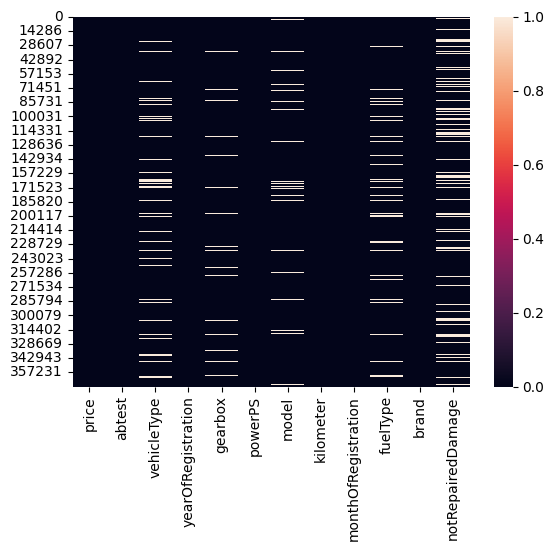

In [25]:
sns.heatmap(base.isnull())

In [26]:
base.loc[pd.isnull(base["vehicleType"])].shape

(33546, 12)

In [27]:
base["vehicleType"].value_counts() #limousine

vehicleType
limousine     93614
kleinwagen    78014
kombi         65921
bus           29699
cabrio        22509
coupe         18386
suv           14477
andere         3125
Name: count, dtype: int64

In [28]:
base.loc[pd.isnull(base["gearbox"])].shape

(17236, 12)

In [29]:
base["gearbox"].value_counts() #manuell

gearbox
manuell      266547
automatik     75508
Name: count, dtype: int64

In [30]:
base.loc[pd.isnull(base["model"])].shape

(17967, 12)

In [31]:
base["model"].value_counts() #golf

model
golf               28989
andere             25560
3er                19905
polo               12604
corsa              12149
                   ...  
serie_2                8
rangerover             6
serie_3                3
serie_1                1
discovery_sport        1
Name: count, Length: 251, dtype: int64

In [32]:
base.loc[pd.isnull(base["fuelType"])].shape

(29391, 12)

In [33]:
base["fuelType"].value_counts() #benzin

fuelType
benzin     217582
diesel     106002
lpg          5222
cng           557
hybrid        271
andere        165
elektro       101
Name: count, dtype: int64

In [34]:
base.loc[pd.isnull(base["notRepairedDamage"])].shape

(65986, 12)

In [35]:
base["notRepairedDamage"].value_counts()

notRepairedDamage
nein    259301
ja       34004
Name: count, dtype: int64

In [36]:
valores = {"vehicleType": "limousine",
           "gearbox": "manuell",
           "model": "golf",
           "fuelType": "benzin",
           "notRepairedDamage": "nein"
}

In [37]:
base = base.fillna(value = valores)

In [38]:
base.isna().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

In [39]:
preco_real = base["price"]

In [40]:
previsores = base.drop(columns="price")

In [41]:
previsores.columns

Index(['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage'],
      dtype='object')

In [42]:
onehotencoder = ColumnTransformer(transformers=[("OneHot", 
                                                 OneHotEncoder(), 
                                                 [0,1,3,5,8,9,10])],
                                                 remainder="passthrough"
                                                )

In [43]:
previsores = onehotencoder.fit_transform(previsores).toarray()

In [44]:
previsores.shape

(359291, 316)

In [45]:
previsores = np.array(previsores)
preco_real = np.array(preco_real)

In [46]:
previsores = previsores.astype('float32')
preco_real = preco_real.astype('float32')

## 3. Construção do modelo

In [47]:
class regressao_torch(nn.Module):
    def __init__(self, activation, neurons, initializer, dropout):
        super().__init__()

        self.dense0 = nn.Linear(316, neurons)
        initializer(self.dense0.weight)
        self.activation0 = activation
        self.dropout0 = nn.Dropout(dropout)
        
        self.dense1 = nn.Linear(neurons, neurons)
        initializer(self.dense0.weight)
        self.activation1 = activation
        self.dropout1 = nn.Dropout(dropout)
        
        self.dense2 = nn.Linear(neurons, 1)

    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.dropout0(X)

        X = self.dense1(X)
        X = self.activation1(X)
        X = self.dropout1(X)

        X = self.dense2(X)
        return X

In [48]:
regressao_sklearn = NeuralNetRegressor(module=regressao_torch,
                                       optimizer__weight_decay=0.0001,
                                       train_split=False)

## 4. Tuning de parâmetros

In [49]:
params = {
    'batch_size': [300],
    'max_epochs': [100],
    'optimizer': [torch.optim.Adam],
    'criterion': [torch.nn.L1Loss, torch.nn.MSELoss, torch.nn.SmoothL1Loss],
    'module__activation': [F.relu],
    'module__neurons': [158],
    'module__initializer': [torch.nn.init.uniform_, torch.nn.init.normal_],
    'module__dropout': [0.2, 0.3]
}

In [50]:
grid_search = GridSearchCV(estimator=regressao_sklearn,
                          param_grid=params,
                          scoring='neg_mean_absolute_error',
                          cv=2,
                          error_score="raise")

In [51]:
grid_search = grid_search.fit(previsores, preco_real)

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5419.6074  1.0357


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4667.1914  1.0262
      3     4666.6757  1.0269
      4     4667.8910  1.0244
      5     4661.4018  1.0243
      6     4660.2143  1.0303
      7     4658.1637  1.0052
      8     4657.0017  1.0093
      9     4655.4937  1.0170
     10     4652.1609  1.0620
     11     4651.1475  1.0274
     12     4653.0787  1.0036
     13     4650.2216  1.0178
     14     4650.3955  1.0124
     15     4650.3735  1.0193
     16     4649.6103  1.0172
     17     4649.0889  1.0118
     18     4649.8011  1.0254
     19     4647.3172  1.0242
     20     4646.8778  1.0185
     21     4648.4620  1.0106
     22     4647.4887  1.0200
     23     4634.0039  1.0104
     24     4608.2196  1.0168
     25     4605.7559  1.0157
     26     4606.7497  1.0165
     27     4605.6441  1.0198
     28     4605.1485  1.0159
     29     4604.7082  1.0126
     30     4597.6836  1.0257
     31     4586.0821  1.0047
     32     4585.6810  1.0158
     33     4585.5667  1.0728
     34     4584.7582  1.0173
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     6166.5808  1.0290


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4904.5503  1.0192
      3     4856.8977  1.0088
      4     4850.3836  1.0149
      5     4820.7822  1.0162
      6     4702.2702  1.0099
      7     4663.0047  1.0234
      8     4658.1107  1.0170
      9     4652.3621  1.0112
     10     4653.1934  1.0222
     11     4640.9027  1.0139
     12     4624.6561  1.0054
     13     4622.8714  1.0093
     14     4623.1232  1.0043
     15     4623.0009  1.0077
     16     4622.8720  1.0218
     17     4622.6789  1.0035
     18     4622.0711  1.0104
     19     4621.7041  1.0078
     20     4621.2298  1.0025
     21     4621.7760  1.0124
     22     4622.3219  1.0196
     23     4621.1386  1.0097
     24     4620.5921  1.0007
     25     4621.9204  0.9961
     26     4621.9470  1.0145
     27     4620.5433  1.0629
     28     4622.0232  1.0114
     29     4621.3831  1.0065
     30     4620.1181  1.0017
     31     4620.3018  1.0085
     32     4621.3580  1.0143
     33     4620.2516  1.0238
     34     4619.4253  1.0042
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5497.5002  1.0198


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4601.5993  1.0108
      3     4601.4222  1.0028
      4     4602.3503  1.0124
      5     4593.8258  1.0040
      6     4593.6662  1.0151
      7     4585.1195  1.0096
      8     4583.9889  1.0155
      9     4582.2947  1.0030
     10     4579.0171  0.9950
     11     4578.1798  1.0137
     12     4579.1607  1.0084
     13     4578.2761  1.0036
     14     4577.6909  1.0098
     15     4579.9813  0.9955
     16     4579.3083  1.0076
     17     4578.9210  1.0079
     18     4579.6034  1.0020
     19     4579.5473  1.0175
     20     4577.2522  1.0105
     21     4578.9427  1.0072
     22     4575.8266  1.0144
     23     4579.6817  1.0042
     24     4578.2838  1.0059
     25     4577.4345  1.0024
     26     4577.0743  1.0113
     27     4577.5638  1.0109
     28     4575.8921  1.0155
     29     4572.4489  1.0164
     30     4572.7835  1.0089
     31     4569.1745  1.0716
     32     4571.0272  1.0149
     33     4570.4983  1.0038
     34     4570.4385  1.0107
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5500.8866  1.0131


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4635.4181  1.0013
      3     4642.3194  1.0522
      4     4643.9725  1.0125
      5     4641.1092  1.0007
      6     4635.2928  0.9902
      7     4629.0086  0.9989
      8     4622.4749  0.9895
      9     4615.2999  0.9936
     10     4605.3322  0.9954
     11     4604.4318  1.0019
     12     4602.6715  1.0024
     13     4601.8442  0.9971
     14     4601.3782  0.9972
     15     4606.2874  0.9975
     16     4602.0033  0.9973
     17     4600.4927  0.9930
     18     4604.9028  1.0243
     19     4599.8034  0.9925
     20     4606.0766  1.0536
     21     4605.8595  1.0178
     22     4603.3396  1.0388
     23     4603.3398  1.0359
     24     4602.3394  1.0105
     25     4603.9781  1.0085
     26     4603.0863  1.0213
     27     4603.3022  1.0111
     28     4600.3696  1.0147
     29     4601.7597  1.0059
     30     4601.1796  1.0290
     31     4605.0006  1.0504
     32     4602.3726  1.0263
     33     4601.6210  1.0112
     34     4603.0355  1.0144
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     6016.7197  1.0388


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4972.4704  1.0806
      3     4940.7255  1.0411
      4     4939.2654  1.0420
      5     4938.3634  1.0395
      6     4934.8524  1.0417
      7     4932.8037  1.0502
      8     4928.5249  1.0545
      9     4929.3484  1.0273
     10     4919.7448  1.0322
     11     4919.5815  1.0418
     12     4917.4454  1.0307
     13     4915.6384  1.0342
     14     4881.3516  1.0444
     15     4729.4094  1.0423
     16     4729.4929  1.0358
     17     4726.5506  1.0236
     18     4726.1134  1.0391
     19     4724.6683  1.0819
     20     4722.5215  1.0797
     21     4721.7318  1.0300
     22     4723.4278  1.0477
     23     4721.6879  1.0426
     24     4720.7937  1.0318
     25     4719.6916  1.0087
     26     4661.6369  1.0196
     27     4657.9352  1.0377
     28     4656.1536  1.0287
     29     4655.9193  1.0448
     30     4654.9870  1.0604
     31     4653.9445  1.0466
     32     4652.5405  1.0497
     33     4655.2627  1.0533
     34     4654.9375  1.0750
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     6946.5494  1.0402


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     5934.8175  1.0573
      3     5928.8296  1.0366
      4     5922.8464  1.0169
      5     5916.8664  1.0339
      6     5910.8893  1.0379
      7     5904.9143  1.0309
      8     5898.9407  1.0274
      9     5892.9722  1.0471
     10     5887.0180  1.0841
     11     5881.0640  1.0547
     12     5875.1097  1.0332
     13     5869.1567  1.0760
     14     5863.2064  1.0218
     15     5857.2611  1.0517
     16     5851.3158  1.0635
     17     5845.3735  1.0421
     18     5839.4773  1.0534
     19     5833.5880  1.0450
     20     5827.6924  1.0370
     21     5821.7987  1.1324
     22     5815.9112  1.0363
     23     5810.0245  1.0318
     24     5806.3724  1.0212
     25     5798.2571  1.0269
     26     5792.4065  1.0313
     27     5785.7954  1.0445
     28     4877.6948  1.0457
     29     4738.6265  1.0321
     30     4703.8304  1.0376
     31     4701.1346  1.0335
     32     4702.9522  1.0553
     33     4700.9308  1.0892
     34     4680.9375  1.0804
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5115.4620  1.0437


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4616.8859  1.0299
      3     4608.9372  1.0489
      4     4603.6152  1.0244
      5     4589.4958  1.0574
      6     4583.9952  1.0709
      7     4579.0818  1.0522
      8     4587.0376  1.0348
      9     4582.0924  1.0425
     10     4581.9173  1.0268
     11     4584.0266  1.0163
     12     4581.5571  1.0308
     13     4579.4056  1.0252
     14     4579.5422  1.0381
     15     4577.8722  1.0522
     16     4578.8023  1.0306
     17     4579.4580  1.0171
     18     4579.4169  1.0529
     19     4579.2429  1.0682
     20     4578.9991  1.0355
     21     4576.0276  1.0410
     22     4576.1563  1.0229
     23     4575.6747  1.0266
     24     4575.8959  1.0392
     25     4575.2166  1.0303
     26     4576.5654  1.0507
     27     4575.6061  1.0324
     28     4576.8042  1.0205
     29     4577.5645  1.0118
     30     4576.7281  1.0264
     31     4577.2503  1.0164
     32     4576.8703  1.0312
     33     4575.4999  1.0318
     34     4575.3635  1.0443
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5566.3132  1.0258


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4654.2292  1.0354
      3     4666.5522  1.1082
      4     4663.3593  1.0446
      5     4654.1255  1.0444
      6     4643.9796  1.0761
      7     4628.9475  926.4093
      8     4619.2589  1.0834
      9     4615.4822  1.0679
     10     4622.5065  1.0733
     11     4623.5084  1.0610
     12     4621.2174  1.0392
     13     4616.1618  1.0495
     14     4612.7385  1.0308
     15     4615.6931  1.0231
     16     4619.7006  1.0326
     17     4614.8589  1.0233
     18     4621.4629  1.0607
     19     4616.6659  1.0433
     20     4617.1365  1.0358
     21     4617.8225  1.0350
     22     4623.9153  1.0620
     23     4623.5816  1.0512
     24     4621.9930  1.0324
     25     4621.6280  1.0367
     26     4619.4356  1.0398
     27     4622.7384  1.0388
     28     4620.2734  1.0379
     29     4621.1396  1.0415
     30     4621.1142  1.0495
     31     4620.9017  1.0371
     32     4620.4627  1.0492
     33     4621.6456  1.0289
     34     4621.5014  1.0350
     35 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  351017941.0603  0.9822


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  82960585.1725  0.9753
      3  82949869.9287  0.9850
      4  82948895.8957  0.9883
      5  82899777.5103  0.9808
      6  82728359.7611  0.9842
      7  82204333.7037  0.9735
      8  81081728.4222  1.0061
      9  80765416.7751  0.9707
     10  80802296.9257  926.2113
     11  80754723.5399  1.0660
     12  80823845.1604  0.9655
     13  80868828.6224  0.9701
     14  80837743.4239  0.9651
     15  80735313.2019  0.9668
     16  80676945.3066  1.0290
     17  80675802.4159  0.9666
     18  80516787.0679  0.9591
     19  80481259.6734  0.9658
     20  80460044.6189  0.9580
     21  80402993.2618  0.9623
     22  80469816.0269  0.9773
     23  80470202.7435  0.9507
     24  80457714.4672  0.9626
     25  80422810.9778  0.9659
     26  80403186.1821  0.9678
     27  80406202.4487  0.9681
     28  80402647.1041  0.9702
     29  80362213.2824  0.9492
     30  80389764.8739  0.9628
     31  80359018.9706  0.9689
     32  80352482.2284  0.9711
     33  80340261.8305  0.9691
     3

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  295681024.0102  0.9836


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  85821977.4497  1.0153
      3  85707498.3700  0.9816
      4  84441983.7352  0.9696
      5  83756804.7845  926.4311
      6  83541086.0848  0.9642
      7  83567827.5070  0.9708
      8  83653917.1012  0.9565
      9  83723576.1893  0.9760
     10  83724669.3996  0.9665
     11  83694025.4597  0.9586
     12  83785291.3288  0.9718
     13  83731611.6957  0.9478
     14  83686466.6102  0.9577
     15  83593122.8292  0.9568
     16  83490445.8658  0.9710
     17  83401821.0390  0.9546
     18  83366228.8012  1.0488
     19  83332408.2447  1.2508
     20  83290801.8462  0.9763
     21  83242503.4123  0.9708
     22  83264213.1113  1.9724
     23  82297966.1676  0.9587
     24  82134743.5730  0.9902
     25  82089269.1221  1.0102
     26  82079435.3833  1.0656
     27  82074049.0848  1.0065
     28  82031655.1275  1.0905
     29  82059958.8082  0.9819
     30  82024066.4385  0.9614
     31  82034835.5106  0.9699
     32  82080407.2032  0.9864
     33  82012154.9775  1.0242
     3

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  238500686.0357  0.9907


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  78559100.8985  0.9894
      3  78149494.9901  0.9881
      4  77946331.4800  0.9905
      5  77848693.4201  0.9874
      6  77825739.2070  0.9915
      7  77811538.1603  0.9909
      8  77942571.8588  0.9810
      9  78119182.2331  0.9861
     10  78153935.5294  0.9711
     11  78351662.8572  0.9829
     12  78495713.7722  0.9704
     13  78535543.0979  1.0002
     14  78408632.7049  1.0567
     15  78176251.5521  1.5291
     16  78062023.3965  1.3270
     17  77897856.2492  1.3020
     18  77772313.4585  1.0062
     19  77733996.4037  0.9937
     20  77726864.3616  0.9873
     21  77804381.0926  0.9877
     22  77747255.7079  1.0207
     23  77822880.2351  0.9909
     24  77820576.9872  0.9922
     25  77825221.5253  0.9932
     26  77808240.9638  0.9884
     27  77816425.8671  0.9966
     28  77841003.0444  1.0214
     29  77782368.1717  1.0146
     30  77788276.9573  1.0253
     31  77789082.4148  1.0213
     32  77805072.8754  1.0213
     33  77779031.1394  1.0167
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  362806491.8229  1.1504


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  82322135.9955  1.1424
      3  82502044.9304  1.1437
      4  82469894.6380  1.1707
      5  82358838.6336  1.2104
      6  82307718.4250  1.1811
      7  82251586.8610  1.1488
      8  82155800.7337  1.1567
      9  82288830.8035  1.1534
     10  82422608.7977  1.1709
     11  82422769.8884  1.1861
     12  82526034.6163  1.1711
     13  82591225.3957  1.1742
     14  82535366.4282  1.1898
     15  82632756.2155  1.2686
     16  82516641.6730  1.1788
     17  82522883.4641  1.1743
     18  82533353.8931  1.1845
     19  82324603.7291  1.1922
     20  82174180.3830  1.1775
     21  82162234.7954  1.2302
     22  82088721.7839  1.1916
     23  82123512.5690  1.1996
     24  82066461.3555  1.1935
     25  82140045.3659  1.1822
     26  82097261.7466  1.1773
     27  82085039.4776  1.1850
     28  82092806.0120  1.1817
     29  82078017.7766  1.1797
     30  82084860.2691  1.1619
     31  82055574.5101  1.1951
     32  82079683.4035  1.1839
     33  82039444.3632  1.1770
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  282600377.9417  4.7149


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  82641903.0945  4.6590
      3  82293777.0021  4.9771
      4  81017189.3462  4.7804
      5  80662955.9560  4.6756
      6  80723151.7867  4.6912
      7  80847194.9529  4.6361
      8  80869916.9650  4.6868
      9  80751058.1069  4.6739
     10  80779184.7623  4.6509
     11  80800550.5552  2.6288
     12  80700811.9667  1.2353
     13  80615226.2297  1.2171
     14  80573592.2218  1.2169
     15  80435133.3902  1.2289
     16  80250848.2813  1.2048
     17  80162425.7769  1.2168
     18  80151844.1704  1.2206
     19  80119270.8960  1.2173
     20  80147739.1710  1.2889
     21  80121374.2278  1.2485
     22  80116321.5145  1.2042
     23  80118649.3155  1.2215
     24  80081768.8045  1.2179
     25  80117672.3795  1.2147
     26  80182593.4142  1.2433
     27  80117351.8441  1.1941
     28  80052415.1888  1.2381
     29  80098562.8139  1.1916
     30  80111274.4797  1.2164
     31  80066836.4119  1.2370
     32  80083901.8758  1.1965
     33  80052793.5828  1.2867
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  124587544.9949  1.6476


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  90667983.0996  1.6569
      3  86859053.7249  1.7939
      4  85918598.4431  1.6667
      5  85929632.8283  1.6520
      6  86035333.8260  3.6322
      7  85981825.5250  4.7099
      8  85938304.5586  4.6682
      9  84626595.7754  4.7337
     10  84220425.9074  4.6645
     11  84034629.7310  4.6721
     12  83944139.6589  4.6712
     13  83894669.2908  4.6521
     14  83824493.3831  4.6623
     15  83844677.7798  4.6619
     16  83812213.0653  4.6951
     17  83767380.7646  4.6413
     18  83778006.9521  4.8820
     19  83733839.6070  4.6935
     20  83727681.8805  4.6708
     21  83804806.4771  4.6461
     22  83756400.0823  4.9343
     23  83721058.8324  4.6722
     24  83712763.1256  4.6854
     25  83732519.0354  4.6689
     26  83728078.1536  4.7250
     27  83727470.0442  4.6809
     28  83682217.3970  4.6636
     29  83693051.4028  4.7641
     30  83653993.2137  4.9599
     31  83647140.1081  4.7160
     32  83677229.9872  4.7495
     33  83607778.4359  4.7623
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  173432360.4467  3.3911


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  80594432.0902  3.7592
      3  80585147.9760  3.2168
      4  80615149.1594  3.5601
      5  80656621.1891  3.2311
      6  80626356.7370  3.5530
      7  80638998.0891  3.2619
      8  80573052.0907  3.1891
      9  80702835.2237  3.2449
     10  80593111.0940  3.2679
     11  80555563.8690  3.2994
     12  80562783.4014  3.2396
     13  80509824.0922  3.2321
     14  80355023.6972  3.2054
     15  79906496.2016  3.2090
     16  79250438.6488  3.2860
     17  79081116.5720  3.2403
     18  79000730.3093  3.2489
     19  78945048.2954  3.3121
     20  78973361.5888  3.5806
     21  78912254.7963  3.4886
     22  78921347.6870  3.3558
     23  78913091.0000  3.2841
     24  78897745.8277  3.1965
     25  78921880.2999  3.5392
     26  78992568.5454  3.1967
     27  78927459.2935  3.1820
     28  78870987.3283  3.5274
     29  78948121.0654  3.2189
     30  78902787.2935  3.3399
     31  78913705.3425  3.4830
     32  78915672.7191  3.4354
     33  78903897.5052  3.3623
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch      train_loss     dur
-------  --------------  ------
      1  260555528.7793  3.2194


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2  82936675.8302  3.2679
      3  82835193.1203  3.2058
      4  82880445.9144  3.2664
      5  82828098.1359  3.2784
      6  82635220.3547  3.2516
      7  82625839.0846  3.3058
      8  82763130.8692  3.2476
      9  82696105.5724  3.3164
     10  82669707.9026  3.1502
     11  82794338.2840  3.3430
     12  82622942.7873  3.6848
     13  82559869.4339  3.2950
     14  82458357.3516  3.2599
     15  82310879.2495  3.2372
     16  82270005.8818  3.2563
     17  82190925.0913  3.2659
     18  81964023.3911  3.3709
     19  81873079.7983  3.2899
     20  81829755.1966  3.2897
     21  81817676.9714  3.4869
     22  81888619.9345  3.4067
     23  81905443.5394  3.3658
     24  81892122.2984  3.3642
     25  81902939.0799  3.4051
     26  81936561.7144  3.4343
     27  81917544.0856  3.3742
     28  81913460.9599  3.5779
     29  81867918.1748  3.4094
     30  81884351.6692  3.5756
     31  81893387.2883  3.2878
     32  81868329.1198  3.2708
     33  81855020.1049  3.2033
     34 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     5873.3320  3.8155


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4832.4637  3.3748
      3     4807.0160  3.2694
      4     4806.7239  3.3466
      5     4802.8719  3.4078
      6     4799.9021  3.7147
      7     4800.2532  3.2425
      8     4797.5665  3.2783
      9     4794.1319  3.3345
     10     4787.5978  3.5633
     11     4786.5514  3.3254
     12     4786.8147  3.6184
     13     4785.6579  3.2872
     14     4786.8439  3.4347
     15     4782.2406  3.4432
     16     4764.0276  3.4920
     17     4650.5521  4.0280
     18     4647.5934  3.6608
     19     4646.0982  3.2219
     20     4644.3892  3.3862
     21     4645.9737  3.4440
     22     4633.8939  3.3769
     23     4605.6981  3.3393
     24     4604.0075  3.3276
     25     4603.3490  3.2277
     26     4603.6520  3.3978
     27     4604.3982  3.4360
     28     4603.6908  3.2535
     29     4601.2093  3.2283
     30     4587.4736  3.4303
     31     4585.3001  3.3171
     32     4587.2730  3.3528
     33     4584.4259  3.3676
     34     4584.7868  3.4548
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     5822.6188  3.2288


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4685.9686  3.2412
      3     4685.3956  3.2310
      4     4684.9598  3.3755
      5     4674.9280  3.5095
      6     4670.0595  3.6617
      7     4662.7134  3.7147
      8     4659.6391  3.2501
      9     4655.3481  3.2265
     10     4651.7937  3.2208
     11     4653.9823  3.2519
     12     4652.8778  3.2057
     13     4652.7380  3.3665
     14     4653.2507  3.2644
     15     4652.5083  3.2861
     16     4652.1754  3.3063
     17     4653.6864  3.2924
     18     4652.5758  3.2928
     19     4652.0374  3.3202
     20     4651.9040  3.2480
     21     4651.5157  3.2107
     22     4651.2917  3.2907
     23     4650.5941  3.2826
     24     4650.2202  3.2374
     25     4651.9407  3.6059
     26     4649.3979  3.2112
     27     4649.5421  3.2566
     28     4649.1127  3.3695
     29     4649.6149  3.4117
     30     4648.8676  3.4191
     31     4648.7405  3.3241
     32     4648.9700  3.3796
     33     4648.5263  3.3297
     34     4648.6473  3.5343
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     5438.9869  3.2987


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4582.8305  3.2693
      3     4579.1324  3.4950
      4     4580.3221  3.3082
      5     4578.0574  3.3870
      6     4571.5447  3.2597
      7     4567.2938  3.2527
      8     4569.1187  3.2786
      9     4564.5675  3.2840
     10     4567.7029  3.2738
     11     4567.0613  3.3006
     12     4565.2654  3.2330
     13     4566.0572  3.2088
     14     4566.2434  3.8891
     15     4566.8657  3.2920
     16     4566.5133  3.3018
     17     4565.0527  3.2432
     18     4565.7613  3.2704
     19     4562.9638  3.2805
     20     4562.7491  3.2511
     21     4561.4243  3.2614
     22     4563.3080  3.2628
     23     4564.2917  3.3202
     24     4562.7318  3.2614
     25     4564.2094  3.2486
     26     4560.1299  3.2011
     27     4564.1550  3.2433
     28     4561.5514  3.2627
     29     4562.8244  3.3733
     30     4561.4487  3.2155
     31     4563.6193  3.2298
     32     4564.1190  3.5827
     33     4563.9474  3.2793
     34     4562.4749  3.2471
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     6831.0055  3.3390


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     5934.2432  3.2460
      3     5928.2492  3.1924
      4     5922.2634  3.4911
      5     5916.2823  3.2069
      6     5910.3042  3.2190
      7     5904.3290  3.1659
      8     5898.3552  3.2111
      9     5892.3870  3.1975
     10     5886.4327  3.2861
     11     5880.4786  3.2233
     12     5877.4123  3.2935
     13     5874.7825  3.3049
     14     5862.6446  3.1725
     15     5856.6969  3.1600
     16     5850.7503  3.2682
     17     5845.3498  3.1900
     18     5838.9200  3.1908
     19     5833.0294  3.6420
     20     5827.2478  3.1665
     21     5828.7452  3.1504
     22     4932.8915  3.7107
     23     4669.7647  3.3220
     24     4662.8830  3.2233
     25     4653.6989  3.2160
     26     4636.3366  3.2707
     27     4631.7769  3.2129
     28     4622.0512  3.2192
     29     4615.1653  3.2222
     30     4612.7902  3.2279
     31     4611.6186  3.2875
     32     4611.0044  3.2611
     33     4605.7086  3.2288
     34     4608.1247  3.2103
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     6008.7281  3.2277


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4970.3594  3.1956
      3     4945.6813  3.3083
      4     4942.8392  3.1898
      5     4937.7983  3.2505
      6     4934.2528  3.1958
      7     4932.0558  3.1883
      8     4929.2861  3.3265
      9     4924.6354  3.2729
     10     4924.1962  3.2500
     11     4918.3271  3.2272
     12     4827.8695  3.6040
     13     4729.0894  3.3389
     14     4728.0292  3.2174
     15     4727.9599  3.1960
     16     4725.6269  3.1987
     17     4724.6175  3.2776
     18     4723.5535  3.2175
     19     4723.3956  3.2422
     20     4724.5156  3.1743
     21     4722.1158  3.2105
     22     4721.6755  3.2547
     23     4719.6161  3.2200
     24     4698.6723  3.2861
     25     4658.9521  3.3390
     26     4656.5456  3.2290
     27     4655.5078  3.3029
     28     4656.9709  3.5220
     29     4656.1509  3.3008
     30     4653.9142  3.1995
     31     4658.1099  3.8196
     32     4651.7562  3.4091
     33     4652.9211  3.3708
     34     4639.6010  3.5183
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     6974.6177  3.1674


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     5934.2589  3.5729
      3     5928.2585  3.1986
      4     5922.2697  3.2249
      5     5916.2870  3.1749
      6     5910.3084  3.2173
      7     5904.3326  3.2388
      8     5898.3587  3.2492
      9     5892.3903  3.2509
     10     5886.4359  3.4228
     11     5880.4818  3.2615
     12     5874.5276  3.2180
     13     5868.5744  3.1980
     14     5862.6242  3.2444
     15     5856.6789  3.2465
     16     5850.7337  3.3120
     17     5844.7921  3.2774
     18     5838.8963  4.4058
     19     5833.0069  3.2323
     20     5827.1111  3.6354
     21     5834.7411  3.2096
     22     5720.0086  3.1843
     23     4666.6823  3.2345
     24     4645.4270  3.2225
     25     4640.4079  3.4627
     26     4639.8577  3.3143
     27     4639.0815  3.3908
     28     4637.9332  3.3610
     29     4639.3104  3.4170
     30     4638.3145  3.4485
     31     4640.1511  3.2584
     32     4639.8819  3.3604
     33     4638.2830  3.2587
     34     4636.9364  3.2595
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     5824.2724  0.9959


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([245])) that is different to the input size (torch.Size([245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4733.5711  0.9780
      3     4651.5612  0.9807
      4     4644.5510  0.9897
      5     4643.8503  0.9840
      6     4645.4181  1.0255
      7     4640.0401  1.0322
      8     4629.0451  1.1267
      9     4617.1841  1.0072
     10     4613.7799  1.0064
     11     4612.7562  0.9949
     12     4612.4704  1.0051
     13     4612.2731  0.9834
     14     4613.2730  0.9876
     15     4613.4615  0.9809
     16     4611.9526  0.9947
     17     4612.0685  0.9912
     18     4610.8101  0.9851
     19     4610.5146  0.9900
     20     4613.8129  0.9857
     21     4609.6234  0.9823
     22     4612.8030  0.9870
     23     4610.7155  0.9873
     24     4612.1302  0.9790
     25     4610.3256  0.9923
     26     4612.1537  0.9810
     27     4611.6752  0.9776
     28     4607.8791  0.9758
     29     4611.8876  0.9817
     30     4609.3624  1.0097
     31     4610.4061  0.9821
     32     4608.6256  924.0402
     33     4610.4135  1.0410
     34     4607.3762  0.9765
     35 

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


  epoch    train_loss     dur
-------  ------------  ------
      1     5614.4765  1.0573


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([246])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


      2     4676.5999  1.0487
      3     4664.8443  1.0718
      4     4664.6712  1.0650
      5     4659.7718  1.1819
      6     4655.9442  1.0819
      7     4648.1613  1.0753
      8     4639.2966  1.1013
      9     4631.9318  1.0687
     10     4623.2526  1.0683
     11     4620.5280  1.0904
     12     4620.1860  1.1071
     13     4622.9269  1.0796
     14     4621.8595  1.0894
     15     4632.2865  1.0796
     16     4631.3999  1.0655
     17     4630.4294  1.0576
     18     4630.4158  1.0831
     19     4628.9889  1.0748
     20     4628.8875  1.0819
     21     4629.1730  1.0818
     22     4629.2209  1.1014
     23     4629.2269  1.0925
     24     4630.3780  1.0901
     25     4629.3360  1.1074
     26     4629.9512  1.1135
     27     4628.8079  1.1175
     28     4628.7224  1.1050
     29     4627.4028  1.1113
     30     4629.2668  1.1160
     31     4627.8716  1.1147
     32     4628.8968  1.1042
     33     4627.4716  1.1173
     34     4628.4568  1.1121
     35   

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss     dur
-------  ------------  ------
      1     5656.7894  2.4801


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([191])) that is different to the input size (torch.Size([191, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2     4970.8629  2.4344
      3     4964.5731  2.4774
      4     4960.7350  2.5396
      5     4959.4025  2.4632
      6     4948.6961  2.5116
      7     4939.3836  2.5099
      8     4935.2077  2.4832
      9     4931.1619  2.5212
     10     4928.6503  2.5466
     11     4925.5078  2.5441
     12     4827.4229  2.5462
     13     4741.6071  2.5269
     14     4653.0090  2.5563
     15     4646.3910  2.5935
     16     4646.0684  2.6732
     17     4641.1955  4.8533
     18     4627.7832  10.5701
     19     4628.2246  11.2933
     20     4624.7153  9.8442
     21     4625.4717  9.6350
     22     4625.7221  9.5970
     23     4626.8758  9.5469
     24     4615.8012  9.7445
     25     4614.7555  9.8747
     26     4612.7348  10.0853
     27     4614.2810  9.7130
     28     4610.5714  9.8229
     29     4616.2979  9.4832
     30     4613.9663  9.5465
     31     4615.3838  9.6117
     32     4615.2330  10.0984
     33     4614.3384  6.4574
     34     4616.3446  2.4699
     3

## 6. Resultados

In [52]:
melhores_parametros = grid_search.best_params_
melhor_mae = grid_search.best_score_

In [53]:
melhores_parametros

{'batch_size': 300,
 'criterion': torch.nn.modules.loss.L1Loss,
 'max_epochs': 100,
 'module__activation': <function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>,
 'module__dropout': 0.3,
 'module__initializer': <function torch.nn.init.normal_(tensor: torch.Tensor, mean: float = 0.0, std: float = 1.0, generator: Optional[torch._C.Generator] = None) -> torch.Tensor>,
 'module__neurons': 158,
 'optimizer': torch.optim.adam.Adam}

In [54]:
melhor_mae

np.float64(-4529.0771484375)